# Train Model

Train a classification model using scikit-learn to predict high-spending customers

## 1. Setup and Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import joblib

## 2. Load Preprocessed Data

In [2]:
train_data = pd.read_csv('train_data.csv')
test_data = pd.read_csv('test_data.csv')
print("Loaded pre-split train/test data")
print(f"Train shape: {train_data.shape}")
print(f"Test shape: {test_data.shape}")
    
# Combine for feature preparation
data = pd.concat([train_data, test_data], ignore_index=True)

# Display basic info
print("\nDataset Overview:")
print(data.info())
print("\nTarget variable distribution:")
print(data['target'].value_counts())

Loaded pre-split train/test data
Train shape: (47, 12)
Test shape: (12, 12)

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   total_orders       59 non-null     int64  
 1   total_spent        59 non-null     float64
 2   avg_order_value    59 non-null     float64
 3   orders_per_dollar  59 non-null     float64
 4   high_avg_order     59 non-null     int64  
 5   country_Brazil     59 non-null     bool   
 6   country_Canada     59 non-null     bool   
 7   country_France     59 non-null     bool   
 8   country_Germany    59 non-null     bool   
 9   country_Other      59 non-null     bool   
 10  country_USA        59 non-null     bool   
 11  target             59 non-null     int64  
dtypes: bool(6), float64(3), int64(3)
memory usage: 3.2 KB
None

Target variable distribution:
target
0    45
1    14
Name: count,

## 3. Prepare Features and Target

Separate features (X) and target variable (y).

In [3]:
# Define target variable (is_high_spender)
target_column = 'target'

# Define feature columns (exclude target and ID columns)
id_columns = ['customer_id', 'invoice_id']
feature_columns = [col for col in data.columns 
                  if col != target_column and col not in id_columns]

print("Feature columns:")
for i, col in enumerate(feature_columns, 1):
    print(f"  {i}. {col}")

# Prepare X and y
X = data[feature_columns]
y = data[target_column]

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"\nClass distribution:")
print(f"  High spenders: {y.sum()} ({y.mean():.2%})")
print(f"  Regular spenders: {len(y) - y.sum()} ({(1-y.mean()):.2%})")

Feature columns:
  1. total_orders
  2. total_spent
  3. avg_order_value
  4. orders_per_dollar
  5. high_avg_order
  6. country_Brazil
  7. country_Canada
  8. country_France
  9. country_Germany
  10. country_Other
  11. country_USA

Feature matrix shape: (59, 11)
Target vector shape: (59,)

Class distribution:
  High spenders: 14 (23.73%)
  Regular spenders: 45 (76.27%)


## 4. Train/Test Split

Split the data into training and testing sets.

In [4]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y  # Ensure balanced class distribution
)

print("Data split completed!")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nTraining set class distribution:")
print(f"  High spenders: {y_train.sum()} ({y_train.mean():.2%})")
print(f"  Regular spenders: {len(y_train) - y_train.sum()} ({(1-y_train.mean()):.2%})")

# Scale features if needed
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nFeatures scaled using StandardScaler")

Data split completed!
Training set: 47 samples
Test set: 12 samples

Training set class distribution:
  High spenders: 11 (23.40%)
  Regular spenders: 36 (76.60%)

Features scaled using StandardScaler


## 5. Train Multiple Models

Train different classification models and compare their performance.

In [5]:
# Define models to train
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42),
    'Support Vector Machine': SVC(random_state=42, probability=True)
}

# Dictionary to store trained models and results
trained_models = {}
results = {}

print("Training models...\n")

for name, model in models.items():
    
    # Use scaled data for Logistic Regression and SVM
    if name in ['Logistic Regression', 'Support Vector Machine']:
        X_train_use = X_train_scaled
        X_test_use = X_test_scaled
    else:
        X_train_use = X_train
        X_test_use = X_test
    
    # Train model
    model.fit(X_train_use, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_use)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    # Cross-validation score
    cv_scores = cross_val_score(model, X_train_use, y_train, cv=5)
    
    # Store results
    trained_models[name] = model
    results[name] = {
        'accuracy': accuracy,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'predictions': y_pred
    }
    
    print(f"{name} - Accuracy: {accuracy:.4f}, CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")

print("\nAll models trained successfully!")

Training models...

Random Forest - Accuracy: 1.0000, CV Score: 0.9778 (+/- 0.0889)
Logistic Regression - Accuracy: 1.0000, CV Score: 0.9133 (+/- 0.1653)
Support Vector Machine - Accuracy: 1.0000, CV Score: 0.9111 (+/- 0.1663)

All models trained successfully!


## 6. Model Evaluation and Comparison

In [6]:
# Create results DataFrame
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Test Accuracy': [results[name]['accuracy'] for name in results.keys()],
    'CV Mean': [results[name]['cv_mean'] for name in results.keys()],
    'CV Std': [results[name]['cv_std'] for name in results.keys()]
})

# Sort by test accuracy
results_df = results_df.sort_values('Test Accuracy', ascending=False)

print("Model Performance Comparison:")
print(results_df.to_string(index=False))

# Find best model
best_model_name = results_df.iloc[0]['Model']
best_model = trained_models[best_model_name]

print(f"\nBest performing model: {best_model_name}")
print(f"   Test Accuracy: {results_df.iloc[0]['Test Accuracy']:.4f}")

Model Performance Comparison:
                 Model  Test Accuracy  CV Mean   CV Std
         Random Forest            1.0 0.977778 0.044444
   Logistic Regression            1.0 0.913333 0.082671
Support Vector Machine            1.0 0.911111 0.083148

Best performing model: Random Forest
   Test Accuracy: 1.0000


## 7. Detailed Evaluation of Best Model

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         3

    accuracy                           1.00        12
   macro avg       1.00      1.00      1.00        12
weighted avg       1.00      1.00      1.00        12


Confusion Matrix:
[[9 0]
 [0 3]]


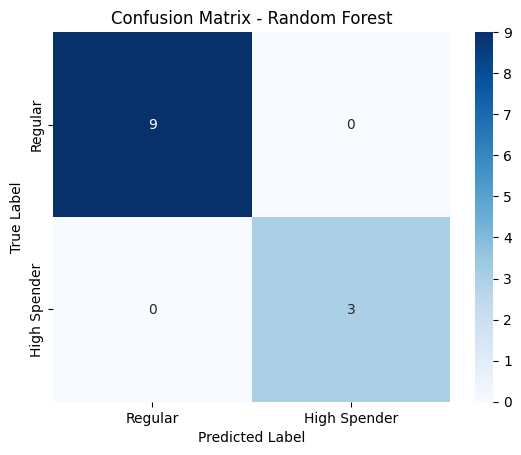


Top 10 Most Important Features (Random Forest):
          feature  importance
orders_per_dollar    0.306245
      total_spent    0.294547
  avg_order_value    0.290614
     total_orders    0.039666
   high_avg_order    0.035628
    country_Other    0.013880
   country_Canada    0.007346
      country_USA    0.005159
  country_Germany    0.004010
   country_France    0.002138


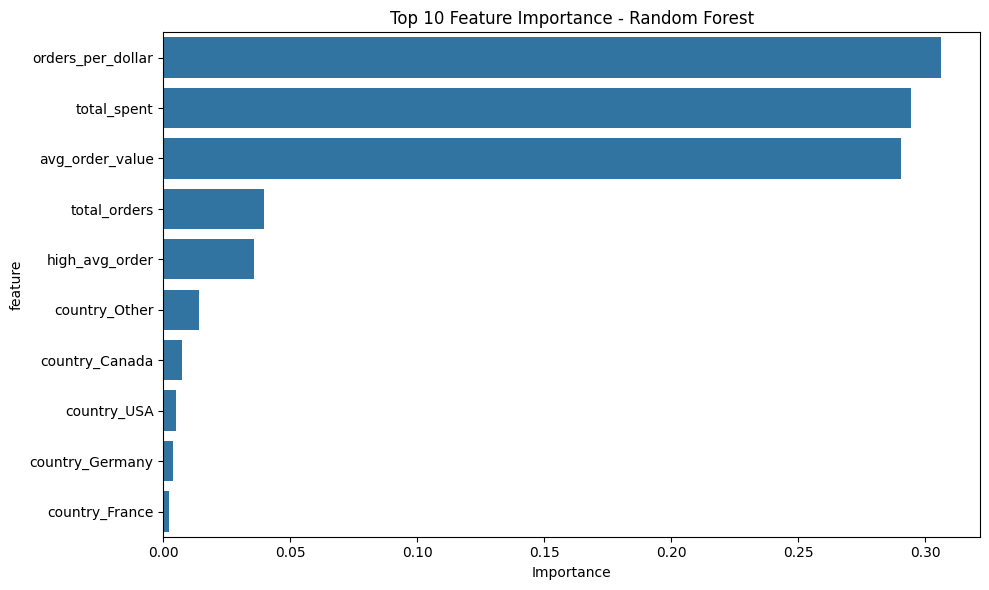

In [7]:
# Get predictions from best model
best_predictions = results[best_model_name]['predictions']
# Classification report
print(f"Classification Report for {best_model_name}:")
print(classification_report(y_test, best_predictions))

# Confusion matrix
cm = confusion_matrix(y_test, best_predictions)
print(f"\nConfusion Matrix:")
print(cm)

# Visualize confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Regular', 'High Spender'], 
            yticklabels=['Regular', 'High Spender'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Feature importance (if available)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': feature_columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\nTop 10 Most Important Features ({best_model_name}):")
    print(feature_importance.head(10).to_string(index=False))
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
    plt.title(f'Top 10 Feature Importance - {best_model_name}')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

## 8. Save Best Model

In [8]:
# Create models directory
import os
os.makedirs('C:/Users/milan/Desktop/chinook/models', exist_ok=True)

# Save best model
model_filename = f'C:/Users/milan/Desktop/chinook/models/best_model_{best_model_name.lower().replace(" ", "_")}.pkl'
joblib.dump(best_model, model_filename)

# Save feature names
feature_names_filename = 'C:/Users/milan/Desktop/chinook/models/feature_names.pkl'
joblib.dump(feature_columns, feature_names_filename)

print(f"Best model saved to {model_filename}")
print(f"Feature names saved to {feature_names_filename}")

# Save results summary
results_filename = 'C:/Users/milan/Desktop/chinook/models/model_results.csv'
results_df.to_csv(results_filename, index=False)
print(f"Results summary saved to {results_filename}")

Best model saved to C:/Users/milan/Desktop/chinook/models/best_model_random_forest.pkl
Feature names saved to C:/Users/milan/Desktop/chinook/models/feature_names.pkl
Results summary saved to C:/Users/milan/Desktop/chinook/models/model_results.csv


## 10. Summary

In [9]:
print("MODEL TRAINING COMPLETE")
print(f"Dataset: {X.shape[0]} samples, {X.shape[1]} features")
print(f"Best Model: {best_model_name}")
print(f"Best Accuracy: {results_df.iloc[0]['Test Accuracy']:.4f}")
print(f"Model saved to: {model_filename}")

MODEL TRAINING COMPLETE
Dataset: 59 samples, 11 features
Best Model: Random Forest
Best Accuracy: 1.0000
Model saved to: C:/Users/milan/Desktop/chinook/models/best_model_random_forest.pkl
